In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

2025-08-17 21:45:09.069905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-17 21:45:09.084955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755481509.106399    9488 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755481509.113183    9488 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755481509.129927    9488 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import tensorflow as tf, gc
tf.keras.backend.clear_session(); gc.collect()

# Bật memory growth (rất quan trọng)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# ================== CONFIG ==================
TRAIN_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/train_preprocess"
VAL_DIR   = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/val_preprocess"

IMAGE_SIZE = 448       # 448 hoặc 512 cho CPU; 600 sẽ rất chậm trên CPU
BATCH_SIZE = 8
SEED = 42

FREEZE_BACKBONE = True   # freeze giai đoạn đầu cho CPU
DROP_RATE = 0.4          # dropout trong head
DENSE_UNITS = 1024

LR = 3e-4
WEIGHT_DECAY = 1e-4
LOSS_W_SOFTMAX = 1.0
LOSS_W_ORDINAL = 0.5

EPOCHS = 15              # ví dụ (bạn tăng sau)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB4

In [5]:
# ========== Ordinal utils ==========
def ordinal_encode_tf(y_int):
    """y_int: (B,) int32 0..4 -> (B,4) float32: [y>=1, y>=2, y>=3, y>=4]"""
    y_int = tf.cast(y_int, tf.int32)
    thresholds = tf.constant([1, 2, 3, 4], dtype=tf.int32)  # (4,)
    y_exp = tf.expand_dims(y_int, axis=-1)                  # (B,1)
    return tf.cast(y_exp >= thresholds, tf.float32)         # (B,4)

def map_preprocess(image, label):
    # image_dataset_from_directory trả image uint8 [0..255]; EfficientNet preprocess sẽ scale
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # -> [0..1] cho EfficientNet
    return image, ordinal_encode_tf(label)




In [6]:
# ========== Dataset loaders (không cache vào RAM) ==========
def make_ds(data_dir, subset="train"):
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",
        class_names=["0","1","2","3","4"],   # cố định thứ tự nhãn
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=(subset=="train"),
        seed=SEED
    )
    ds = ds.map(map_preprocess, num_parallel_calls=AUTOTUNE)
    # ds = ds.map(map_dual_targets, num_parallel_calls=AUTOTUNE)
    # Không dùng .cache() để tiết kiệm RAM; chỉ prefetch
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [7]:
def sca_block(x, ratio=8, name="sca"):
    """Simple Channel Attention: GAP -> 1x1 Conv (reduce) -> 1x1 Conv (gate sigmoid) -> multiply."""
    ch = int(x.shape[-1])
    mid = max(ch // ratio, 1)

    gap = layers.GlobalAveragePooling2D(keepdims=True, name=f"{name}_gap")(x)
    red = layers.Conv2D(mid, 1, padding="same", activation="relu",
                        use_bias=True, name=f"{name}_reduce")(gap)
    gate = layers.Conv2D(ch, 1, padding="same", activation="sigmoid",
                         use_bias=True, name=f"{name}_gate")(red)
    out = layers.Multiply(name=f"{name}_mul")([x, gate])
    return out

In [8]:
# ========== Model builder ==========
def build_model(img_size=IMAGE_SIZE, freeze_backbone=FREEZE_BACKBONE):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Backbone EfficientNet-B4 (ImageNet)
    base = EfficientNetB4(include_top=False, weights="imagenet", input_tensor=inputs)
    base.trainable = not freeze_backbone

    x = base.output
    # CBAM ở feature map cuối (nhẹ)
    x = sca_block(x, ratio=8, name="sca")

    # Global pooling + head chung
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROP_RATE)(x)
    x = layers.Dense(DENSE_UNITS, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROP_RATE * 0.75)(x)

    # Head A: Softmax 5 lớp
    out_soft = layers.Dense(5, activation="softmax", name="softmax")(x)
    # Head B: Ordinal (≥1..4), sigmoid
    out_ord  = layers.Dense(4, activation="sigmoid", name="ordinal")(x)

    model = models.Model(inputs, out_ord, name="EffB4_CBAM_DualHead")
    return model

In [9]:
# ========== Compile ==========
def compile_model(model,
                  lr=LR,
                  wd=WEIGHT_DECAY,
                  ):
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
   

    losses = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    metrics = [tf.keras.metrics.AUC(name="auc", multi_label=True)]

    model.compile(optimizer=optimizer, loss=losses,
                   metrics=metrics)
    return model

In [10]:
# ================== MAIN ==================

print("Loading datasets...")
ds_train = make_ds(TRAIN_DIR, subset="train")
ds_val   = make_ds(VAL_DIR, subset="val")

print("Building model...")
model = build_model()
model = compile_model(model)





Loading datasets...
Found 7324 files belonging to 5 classes.


I0000 00:00:1755481527.037315    9488 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2281 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 366 files belonging to 5 classes.
Building model...


In [11]:
# ===== Hàm mở block và train từng stage =====
def unfreeze_blocks_by_prefix(model, prefixes):
    """Mở các block theo prefix như 'block6', 'block7'"""
    for layer in model.layers:
        if any(layer.name.startswith(pref) for pref in prefixes):
            layer.trainable = True
        elif isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

def run_finetune_stage(model, stage_idx, prefixes, lr, save_path):
    print(f"\n=== Stage {stage_idx}: Unfreeze {prefixes} ===")
    unfreeze_blocks_by_prefix(model, prefixes)

   
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=WEIGHT_DECAY)


    losses = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    metrics = [tf.keras.metrics.AUC(name="auc", multi_label=True)]

    model.compile(optimizer=optimizer, loss=losses,
                   metrics=metrics)

    callbacks_ft = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
        tf.keras.callbacks.ModelCheckpoint(save_path, monitor="val_loss", save_best_only=True)
    ]

    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=10,
        callbacks=callbacks_ft,
        verbose=1
    )
    return history

In [12]:
# Stage definitions: mở block từ 7 → 1
stage_blocks = [
    ["block6", "block7"],
    ["block4", "block5", "block6", "block7"],
    ["block2", "block3", "block4", "block5", "block6", "block7"],
]
stage_lrs = [1e-4, 5e-5, 3e-5]

# Stage 1 checkpoint
stage1_path = "models/effb4_aptos2019_ordinal_v4_stage1.keras"

if os.path.exists(stage1_path):
    print(f"Stage 1 checkpoint found: {stage1_path}, loading...")
    model = tf.keras.models.load_model(stage1_path, compile=False)
else:
    print("\n=== Stage 1: Train head (backbone frozen) ===")
    history1 = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=10,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
            tf.keras.callbacks.ModelCheckpoint(stage1_path, monitor="val_loss", save_best_only=True)
        ],
        verbose=1
    )
    model.save(stage1_path)

# Loop qua stage 2–8
for i, (blocks, lr) in enumerate(zip(stage_blocks, stage_lrs), start=2):
    save_path = f"models/effb4_aptos2019_ordinal_v4_stage{i}.keras"
    if os.path.exists(save_path):
        print(f"Stage {i} checkpoint found: {save_path}, loading...")
        model = tf.keras.models.load_model(save_path, compile=False)
        continue

    model = tf.keras.models.load_model(f"models/effb4_aptos2019_ordinal_v4_stage{i-1}.keras", compile=False)
    run_finetune_stage(model, i, blocks, lr, save_path)

print("\n=== Training pipeline completed ===")

Stage 1 checkpoint found: models/effb4_aptos2019_ordinal_v4_stage1.keras, loading...
Stage 2 checkpoint found: models/effb4_aptos2019_ordinal_v4_stage2.keras, loading...
Stage 3 checkpoint found: models/effb4_aptos2019_ordinal_v4_stage3.keras, loading...

=== Stage 4: Unfreeze ['block2', 'block3', 'block4', 'block5', 'block6', 'block7'] ===
Epoch 1/10


I0000 00:00:1755481572.940719    9632 service.cc:152] XLA service 0x7374a0005120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755481572.940739    9632 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-17 21:46:14.866572: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755481581.550319    9632 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-17 21:46:32.226117: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-17 21:46:32.376981: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup e

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 397, in dispatch_shell

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 368, in execute_request

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 752, in execute_request

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 455, in do_execute

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 577, in run_cell

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_9488/3269341747.py", line 39, in <module>

  File "/tmp/ipykernel_9488/259930203.py", line 30, in run_finetune_stage

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 2625256688 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_121958]

In [1]:
!ipynb-py-convert structure_model_v4_for_aptos2019.ipynb structure_model_v4_for_aptos2019.py

Found 367 files belonging to 5 classes.


2025-08-17 07:55:22.254312: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9282    0.9628       181
           1     0.4531    0.7838    0.5743        37
           2     0.7632    0.5800    0.6591       100
           3     0.2955    0.6842    0.4127        19
           4     0.8667    0.4333    0.5778        30

    accuracy                         0.7657       367
   macro avg     0.6757    0.6819    0.6373       367
weighted avg     0.8330    0.7657    0.7809       367



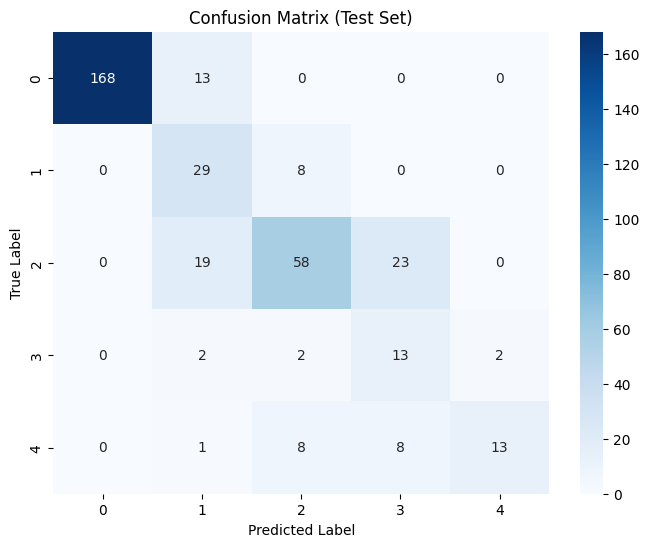

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ================== Config ==================
TEST_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/test_preprocess"   # thư mục test gồm các sub-folder 0..4
IMG_SIZE = 448
BATCH_SIZE = 8
SEED = 42

# ================== Dataset loader ==================
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=["0","1","2","3","4"],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,   # giữ nguyên thứ tự để so sánh
    seed=SEED
)

# ================== Load model ==================
model = tf.keras.models.load_model("models/effb4_aptos2019_ordinal_v4_stage3.keras")

# ================== Predict ==================
# mô hình bạn build đầu ra là 4 sigmoid (ordinal), ta cần decode lại thành nhãn 0..4
def decode_ordinal(y_pred_ord):
    """ y_pred_ord: (N,4) sigmoid output
        -> nhãn int 0..4
    """
    return np.sum(y_pred_ord >= 0.5, axis=1)

# Lấy ground truth
y_true = np.concatenate([y for _, y in test_ds], axis=0)
# Lấy dự đoán từ model
y_pred_raw = model.predict(test_ds, verbose=1)
y_pred = decode_ordinal(y_pred_raw)

# ================== Classification report ==================
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# ================== Confusion matrix ==================
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_18288\1063170478.py:8: SyntaxWarning: invalid escape sequence '\D'
  TEST_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"   # thư mục test gồm các sub-folder 0..4
C:\Users\tran1\AppData\Local\Temp\ipykernel_18288\1063170478.py:27: SyntaxWarning: invalid escape sequence '\D'
  model = tf.keras.models.load_model("D:\Diux\hoctap\DoAn\output_three_models_ddr\effB3_ddr_ordinal_v4_stage2.keras")


Found 1253 files belonging to 5 classes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 547ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.8369    0.9250    0.8788       627
           1     0.1310    0.1746    0.1497        63
           2     0.8020    0.7054    0.7506       448
           3     0.2667    0.1667    0.2051        24
           4     0.9104    0.6703    0.7722        91

    accuracy                         0.7757      1253
   macro avg     0.5894    0.5284    0.5513      1253
weighted avg     0.7834    0.7757    0.7756      1253



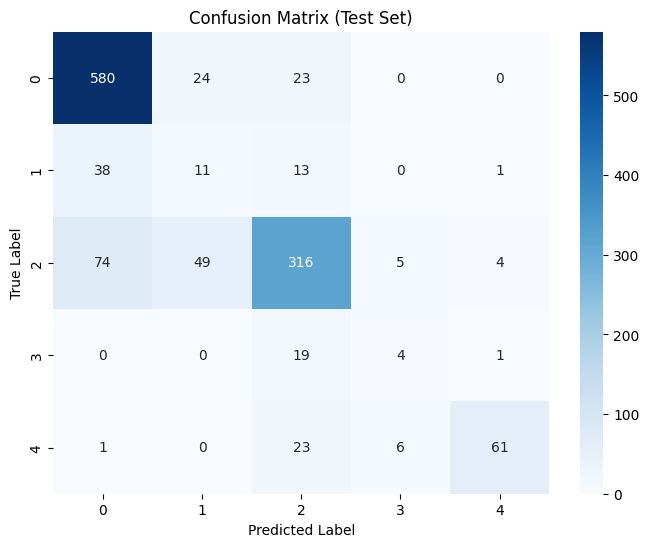

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ================== Config ==================
TEST_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"   # thư mục test gồm các sub-folder 0..4
IMG_SIZE = 300
BATCH_SIZE = 8
SEED = 42

# ================== Dataset loader ==================
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=["0","1","2","3","4"],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,   # giữ nguyên thứ tự để so sánh
    seed=SEED
)

# ================== Load model ==================
model = tf.keras.models.load_model("D:\Diux\hoctap\DoAn\output_three_models_ddr\effB3_ddr_ordinal_v4_stage2.keras")

# ================== Predict ==================
# mô hình bạn build đầu ra là 4 sigmoid (ordinal), ta cần decode lại thành nhãn 0..4
def decode_ordinal(y_pred_ord):
    """ y_pred_ord: (N,4) sigmoid output
        -> nhãn int 0..4
    """
    return np.sum(y_pred_ord >= 0.5, axis=1)

# Lấy ground truth
y_true = np.concatenate([y for _, y in test_ds], axis=0)
# Lấy dự đoán từ model
y_pred_raw = model.predict(test_ds, verbose=1)
y_pred = decode_ordinal(y_pred_raw)

# ================== Classification report ==================
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# ================== Confusion matrix ==================
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()
